In [1]:
# Dependencies
import os
import pandas as pd
from citipy import citipy # get city and country designations based on latitude and longitude
import numpy as np
from pprint import pprint
from config import api_key
import matplotlib.pyplot as plt
import json
import requests
import datetime as dt # to put a datestamp on the outputs

## Create a list of cities

In [2]:
# Create a random list of latitudes and longitudes
# np.random.uniform makes sure that all the numbers in the range get equal chance of getting picked

latitudes = np.random.uniform(-90, 90, size = 2000) # 500 random numbers from -90 to 90 deg latitude
longitudes = np.random.uniform(-180, 180, size = 2000) # 500 random numbers from -180 to 180 deg longitude

coordinates = list(zip(latitudes, longitudes))

In [3]:
# Nearby cities per latitude-longitude pair
cities = []

for coord in coordinates:
    lat, lon = coord
    cities.append(citipy.nearest_city(lat, lon))

In [4]:
# Set of nearby cities
city_names = []
country = []

for city in cities:
    city_names.append(city.city_name) # loop through the city coordinates to get the city names
    country.append(city.country_code) # loop through the city coordinates to get the country codes
    
city_dict ={
    "city": city_names,
    "country": country,
    "latitude": latitudes,
    "longitude": longitudes
           }    

city_df = pd.DataFrame(city_dict)
city_df = city_df.drop_duplicates(["city","country"]) # drop city-country duplicates
city_df = city_df.dropna() # drop rows with missing values

In [5]:
# Save list of nearby cities (for geo-mapping (see Geolocations_WeatherPy.ipynb))
# Get the date today for the file date-stamp
today = dt.datetime.today().strftime('%Y%m%d')

# save the dataframe as a csv file 
city_df.to_csv('city_list_{}.csv'.format(today), index = False, encoding = 'utf-8')

In [6]:
# Add new columns
city_df["Temperature (F)"] = ""
city_df["Humidity (%)"] = ""
city_df["Cloudiness (%)"] = ""
city_df["Wind Speed (mph)"] = ""
city_df.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,ancud,cl,-40.750211,-95.500783,,,,
1,rikitea,pf,-68.748803,-122.842094,,,,
2,amderma,ru,76.217238,63.528456,,,,
3,karasburg,na,-27.778625,19.656871,,,,
4,alofi,nu,-28.965424,-167.028239,,,,


In [7]:
# Get JSON file containing city ID (downloaded)
filepath = os.path.join("Resources","city.list.json")
with open(filepath) as json_file:
    json_data = json.load(json_file)

In [8]:
# Get the city name, country code, and city ID 
# City IDs are recommended by the OpenWeatherMap API because they are unique identifiers. 
# There could be cities in the list with the same name but are located in different countries.

ct_name = []
co_name = []
ct_ID = []

for i in json_data:
    ct_name.append(i["name"]) # city name from JSON file
    co_name.append(i["country"]) # country name from JSON file
    ct_ID.append(i["id"]) # city ID from JSON file

In [9]:
# Put the JSON-sourced data into a dataframe
json_dict = {
    "city": ct_name,
    "country": co_name,
    "city ID": ct_ID}

json_df = pd.DataFrame(json_dict)
json_df["city"] = json_df["city"].str.lower() # make the letters lowercase
json_df["country"] = json_df["country"].str.lower() # make the letters lowercase
json_df.head()

,city,country,city ID
0,hurzuf,ua,707860
1,novinki,ru,519188
2,gorkhā,np,1283378
3,state of haryāna,in,1270260
4,holubynka,ua,708546


In [10]:
# Merge json_df and city_df
city_df2 = pd.merge(city_df,json_df, on = ["city", "country"])
city_df2 = city_df2.drop_duplicates(["city", "country"])
print(f"There are {len(city_df2)} cities in this dataframe.")
city_df2.head()

There are 645 cities in this dataframe.


,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,ancud,cl,-40.750211,-95.500783,,,,,3899695
1,rikitea,pf,-68.748803,-122.842094,,,,,4030556
2,karasburg,na,-27.778625,19.656871,,,,,3356343
3,alofi,nu,-28.965424,-167.028239,,,,,4036284
4,albany,au,-54.260187,110.516247,,,,,7839657


## Get the weather for each city through the OpenWeatherData API

In [11]:
# Formulate the query URL
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Loop through the rows to get the different cities and countries
for index, row in city_df2.iterrows():
    x = row["city"]
    y = row["country"]
    
    # Create a variable for iteration through the dataframe
    city_ID = row["city ID"]
    
    # Create a query URL
    query_url = f"{url}&appid={api_key}&id={city_ID}&units={units}"
    
    # Create a request and JSON-ify
    print(f"Retrieving information for Index {index}: {x},{y} (ID: {city_ID}).")
    response = requests.get(query_url)
    response_json = response.json()
    
    # Extract response
    try:
        print(f"{x},{y} (ID: {city_ID}) has {response_json['clouds']['all']}% cloudiness.")
        
        city_df2.loc[index, "Cloudiness (%)"] = response_json["clouds"]["all"]
        city_df2.loc[index, "Humidity (%)"] = response_json["main"]["humidity"]
        city_df2.loc[index, "Wind Speed (mph)"] = response_json["wind"]["speed"]
        city_df2.loc[index, "Temperature (F)"] = response_json["main"]["temp"]
    
    except (KeyError, IndexError):
        print("The city is not on the list. It will rain meatballs!")
    
    print("----------")

Retrieving information for Index 0: ancud,cl (ID: 3899695).
ancud,cl (ID: 3899695) has 92% cloudiness.
----------
Retrieving information for Index 1: rikitea,pf (ID: 4030556).
rikitea,pf (ID: 4030556) has 8% cloudiness.
----------
Retrieving information for Index 2: karasburg,na (ID: 3356343).
karasburg,na (ID: 3356343) has 0% cloudiness.
----------
Retrieving information for Index 3: alofi,nu (ID: 4036284).
alofi,nu (ID: 4036284) has 92% cloudiness.
----------
Retrieving information for Index 4: albany,au (ID: 7839657).
albany,au (ID: 7839657) has 0% cloudiness.
----------
Retrieving information for Index 6: novoorsk,ru (ID: 518418).
novoorsk,ru (ID: 518418) has 75% cloudiness.
----------
Retrieving information for Index 8: sioux lookout,ca (ID: 6148373).
sioux lookout,ca (ID: 6148373) has 90% cloudiness.
----------
Retrieving information for Index 9: elliot lake,ca (ID: 5947866).
elliot lake,ca (ID: 5947866) has 90% cloudiness.
----------
Retrieving information for Index 10: hermanus

shizunai,jp (ID: 2128025) has 68% cloudiness.
----------
Retrieving information for Index 116: pekan,my (ID: 1734971).
pekan,my (ID: 1734971) has 90% cloudiness.
----------
Retrieving information for Index 117: berlevag,no (ID: 780687).
berlevag,no (ID: 780687) has 40% cloudiness.
----------
Retrieving information for Index 118: kasongo,cd (ID: 213940).
kasongo,cd (ID: 213940) has 44% cloudiness.
----------
Retrieving information for Index 119: yamethin,mm (ID: 1285899).
yamethin,mm (ID: 1285899) has 8% cloudiness.
----------
Retrieving information for Index 120: hasaki,jp (ID: 2112802).
hasaki,jp (ID: 2112802) has 75% cloudiness.
----------
Retrieving information for Index 121: batemans bay,au (ID: 2176639).
batemans bay,au (ID: 2176639) has 64% cloudiness.
----------
Retrieving information for Index 122: tazovskiy,ru (ID: 1489853).
tazovskiy,ru (ID: 1489853) has 92% cloudiness.
----------
Retrieving information for Index 123: baruun-urt,mn (ID: 2032614).
baruun-urt,mn (ID: 2032614) h

lompoc,us (ID: 5367788) has 1% cloudiness.
----------
Retrieving information for Index 189: taoudenni,ml (ID: 2450173).
taoudenni,ml (ID: 2450173) has 0% cloudiness.
----------
Retrieving information for Index 190: bilibino,ru (ID: 2126682).
bilibino,ru (ID: 2126682) has 88% cloudiness.
----------
Retrieving information for Index 191: saldanha,za (ID: 3361934).
saldanha,za (ID: 3361934) has 88% cloudiness.
----------
Retrieving information for Index 192: vestmannaeyjar,is (ID: 3412093).
vestmannaeyjar,is (ID: 3412093) has 92% cloudiness.
----------
Retrieving information for Index 193: norsup,vu (ID: 2135517).
norsup,vu (ID: 2135517) has 56% cloudiness.
----------
Retrieving information for Index 194: bulgan,mn (ID: 2032201).
bulgan,mn (ID: 2032201) has 8% cloudiness.
----------
Retrieving information for Index 199: nuevitas,cu (ID: 3545841).
nuevitas,cu (ID: 3545841) has 40% cloudiness.
----------
Retrieving information for Index 200: santa rosalia,mx (ID: 3983805).
santa rosalia,mx (

matamoros,mx (ID: 3996426) has 5% cloudiness.
----------
Retrieving information for Index 278: half moon bay,us (ID: 5354943).
half moon bay,us (ID: 5354943) has 1% cloudiness.
----------
Retrieving information for Index 279: san policarpo,ph (ID: 1688696).
san policarpo,ph (ID: 1688696) has 80% cloudiness.
----------
Retrieving information for Index 280: astoria,us (ID: 4883749).
astoria,us (ID: 4883749) has 90% cloudiness.
----------
Retrieving information for Index 282: murgab,tm (ID: 1218612).
murgab,tm (ID: 1218612) has 8% cloudiness.
----------
Retrieving information for Index 283: lahaina,us (ID: 5849996).
lahaina,us (ID: 5849996) has 20% cloudiness.
----------
Retrieving information for Index 284: segezha,ru (ID: 497928).
segezha,ru (ID: 497928) has 0% cloudiness.
----------
Retrieving information for Index 286: sekoma,bw (ID: 933102).
sekoma,bw (ID: 933102) has 0% cloudiness.
----------
Retrieving information for Index 287: dikson,ru (ID: 1507390).
dikson,ru (ID: 1507390) has 

herat,af (ID: 1140026) has 0% cloudiness.
----------
Retrieving information for Index 352: san cristobal,ec (ID: 3651949).
san cristobal,ec (ID: 3651949) has 75% cloudiness.
----------
Retrieving information for Index 353: nata,bw (ID: 933238).
nata,bw (ID: 933238) has 100% cloudiness.
----------
Retrieving information for Index 354: north platte,us (ID: 5697939).
north platte,us (ID: 5697939) has 75% cloudiness.
----------
Retrieving information for Index 355: kota,in (ID: 1266049).
kota,in (ID: 1266049) has 0% cloudiness.
----------
Retrieving information for Index 358: kampene,cd (ID: 214575).
kampene,cd (ID: 214575) has 44% cloudiness.
----------
Retrieving information for Index 359: karpathos,gr (ID: 260895).
karpathos,gr (ID: 260895) has 0% cloudiness.
----------
Retrieving information for Index 360: sao jose da coroa grande,br (ID: 3388456).
sao jose da coroa grande,br (ID: 3388456) has 92% cloudiness.
----------
Retrieving information for Index 361: lorengau,pg (ID: 2092164).
l

srandakan,id (ID: 1626493) has 88% cloudiness.
----------
Retrieving information for Index 455: muros,es (ID: 6357322).
muros,es (ID: 6357322) has 40% cloudiness.
----------
Retrieving information for Index 457: nikel,ru (ID: 522260).
nikel,ru (ID: 522260) has 75% cloudiness.
----------
Retrieving information for Index 458: mareeba,au (ID: 2158767).
mareeba,au (ID: 2158767) has 75% cloudiness.
----------
Retrieving information for Index 459: kloulklubed,pw (ID: 7671223).
kloulklubed,pw (ID: 7671223) has 75% cloudiness.
----------
Retrieving information for Index 460: sao joao da barra,br (ID: 3448903).
sao joao da barra,br (ID: 3448903) has 75% cloudiness.
----------
Retrieving information for Index 461: ozernovskiy,ru (ID: 2122293).
ozernovskiy,ru (ID: 2122293) has 12% cloudiness.
----------
Retrieving information for Index 462: arlit,ne (ID: 2447513).
arlit,ne (ID: 2447513) has 0% cloudiness.
----------
Retrieving information for Index 463: oktyabrskoye,ru (ID: 515805).
oktyabrskoye,

brae,gb (ID: 2654970) has 44% cloudiness.
----------
Retrieving information for Index 531: lawrenceburg,us (ID: 4260223).
lawrenceburg,us (ID: 4260223) has 90% cloudiness.
----------
Retrieving information for Index 534: nishihara,jp (ID: 1855342).
nishihara,jp (ID: 1855342) has 90% cloudiness.
----------
Retrieving information for Index 535: praya,id (ID: 1630662).
praya,id (ID: 1630662) has 75% cloudiness.
----------
Retrieving information for Index 538: merauke,id (ID: 2082539).
merauke,id (ID: 2082539) has 32% cloudiness.
----------
Retrieving information for Index 539: port hardy,ca (ID: 6111862).
port hardy,ca (ID: 6111862) has 40% cloudiness.
----------
Retrieving information for Index 540: svetlogorsk,ru (ID: 1490516).
svetlogorsk,ru (ID: 1490516) has 88% cloudiness.
----------
Retrieving information for Index 542: vaitape,pf (ID: 4033077).
vaitape,pf (ID: 4033077) has 36% cloudiness.
----------
Retrieving information for Index 543: iranshahr,ir (ID: 1160939).
iranshahr,ir (ID:

lodja,cd (ID: 211647) has 44% cloudiness.
----------
Retrieving information for Index 614: anadyr,ru (ID: 2127202).
anadyr,ru (ID: 2127202) has 75% cloudiness.
----------
Retrieving information for Index 615: butembo,cd (ID: 217562).
butembo,cd (ID: 217562) has 80% cloudiness.
----------
Retrieving information for Index 616: mabaruma,gy (ID: 3377301).
mabaruma,gy (ID: 3377301) has 0% cloudiness.
----------
Retrieving information for Index 617: ipora,br (ID: 3461090).
ipora,br (ID: 3461090) has 12% cloudiness.
----------
Retrieving information for Index 619: carauari,br (ID: 3664659).
carauari,br (ID: 3664659) has 20% cloudiness.
----------
Retrieving information for Index 620: aki,jp (ID: 1865449).
aki,jp (ID: 1865449) has 90% cloudiness.
----------
Retrieving information for Index 621: yerbogachen,ru (ID: 2012956).
yerbogachen,ru (ID: 2012956) has 0% cloudiness.
----------
Retrieving information for Index 622: portland,au (ID: 2152667).
portland,au (ID: 2152667) has 80% cloudiness.
--

gari,ru (ID: 1506676) has 36% cloudiness.
----------
Retrieving information for Index 719: kharela,in (ID: 1266937).
kharela,in (ID: 1266937) has 0% cloudiness.
----------
Retrieving information for Index 720: chicama,pe (ID: 3698359).
chicama,pe (ID: 3698359) has 0% cloudiness.
----------
Retrieving information for Index 721: namatanai,pg (ID: 2090021).
namatanai,pg (ID: 2090021) has 76% cloudiness.
----------
Retrieving information for Index 722: beringovskiy,ru (ID: 2126710).
beringovskiy,ru (ID: 2126710) has 92% cloudiness.
----------
Retrieving information for Index 723: oussouye,sn (ID: 2246901).
oussouye,sn (ID: 2246901) has 0% cloudiness.
----------
Retrieving information for Index 724: penicuik,gb (ID: 2640465).
penicuik,gb (ID: 2640465) has 0% cloudiness.
----------
Retrieving information for Index 725: coruripe,br (ID: 3465329).
coruripe,br (ID: 3465329) has 8% cloudiness.
----------
Retrieving information for Index 726: nawabganj,in (ID: 1261639).
nawabganj,in (ID: 1261639)

nemuro,jp (ID: 2128975) has 0% cloudiness.
----------
Retrieving information for Index 798: tulun,ru (ID: 2014927).
tulun,ru (ID: 2014927) has 8% cloudiness.
----------
Retrieving information for Index 799: begusarai,in (ID: 1276609).
begusarai,in (ID: 1276609) has 0% cloudiness.
----------
Retrieving information for Index 800: banjar,id (ID: 1650232).
banjar,id (ID: 1650232) has 75% cloudiness.
----------
Retrieving information for Index 804: callaway,us (ID: 4149635).
callaway,us (ID: 4149635) has 20% cloudiness.
----------
Retrieving information for Index 805: zyryanka,ru (ID: 2119283).
zyryanka,ru (ID: 2119283) has 88% cloudiness.
----------
Retrieving information for Index 806: havelock,us (ID: 4470244).
havelock,us (ID: 4470244) has 90% cloudiness.
----------
Retrieving information for Index 807: zhangye,cn (ID: 1785036).
zhangye,cn (ID: 1785036) has 0% cloudiness.
----------
Retrieving information for Index 808: hvide sande,dk (ID: 2619537).
hvide sande,dk (ID: 2619537) has 32% 

In [12]:
# Get the date today for the file date-stamp
today = dt.datetime.today().strftime('%Y%m%d')

# save the dataframe as a csv file 
city_df2.to_csv('weather_output_{}.csv'.format(today), index = False, encoding = 'utf-8')

# Preview the dataframe
city_df2.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,ancud,cl,-40.750211,-95.500783,52.01,99,92,9.55,3899695
1,rikitea,pf,-68.748803,-122.842094,71,100,8,6.64,4030556
2,karasburg,na,-27.778625,19.656871,51.29,64,0,8.99,3356343
3,alofi,nu,-28.965424,-167.028239,80.6,78,92,14.99,4036284
4,albany,au,-54.260187,110.516247,53.45,81,0,7.43,7839657


## Create scatterplots

In [13]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

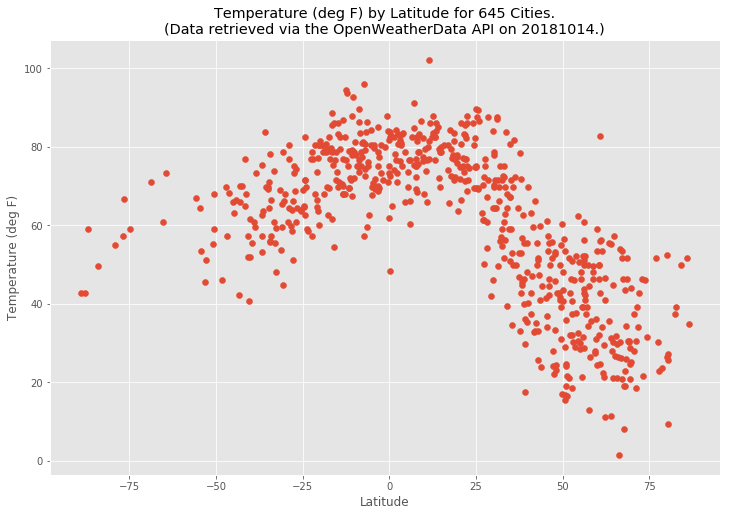

In [14]:
# Latitude vs Temperature
plt.scatter(city_df2["latitude"], city_df2["Temperature (F)"])
plt.xlabel("Latitude")
plt.ylabel("Temperature (deg F)")
plt.title(f"Temperature (deg F) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_temp_{}.png".format(today))
plt.show()

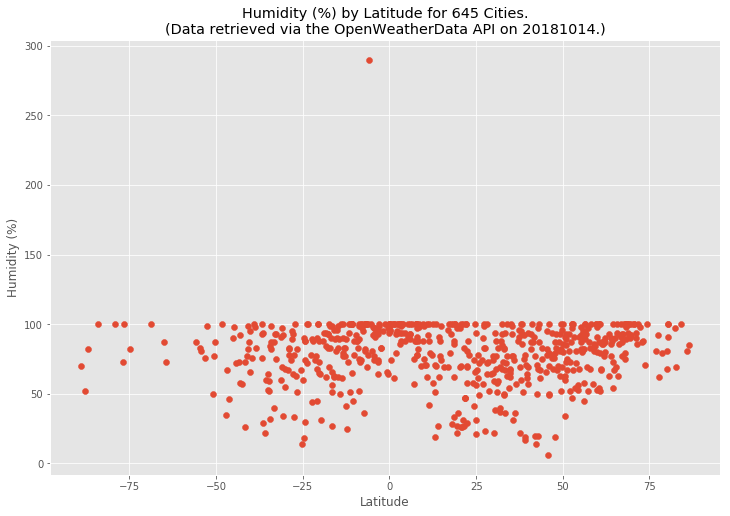

In [15]:
# Latitude vs Humidity
plt.scatter(city_df2["latitude"], city_df2["Humidity (%)"])
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Humidity (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_hum_{}.png".format(today))
plt.show()

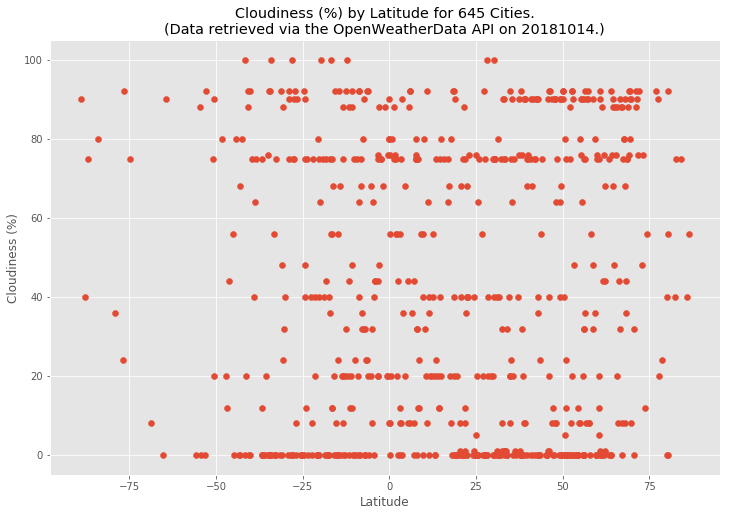

In [16]:
# Latitude vs Cloudiness
plt.scatter(city_df2["latitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_cloud_{}.png".format(today))
plt.show()

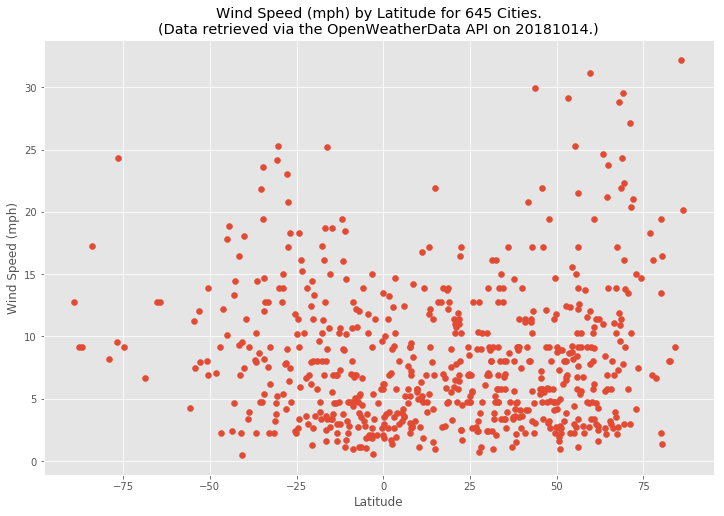

In [17]:
# Latitude vs Wind Speed
plt.scatter(city_df2["latitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_wind_{}.png".format(today))
plt.show()

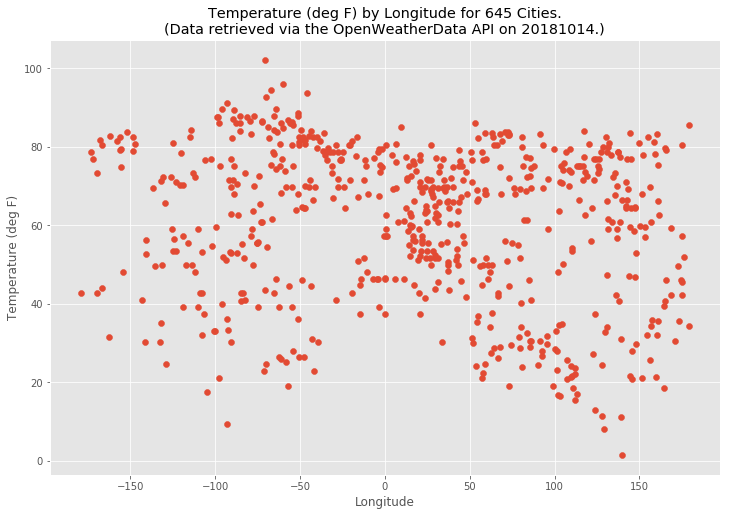

In [18]:
# Longitude vs Temperature
plt.scatter(city_df2["longitude"], city_df2["Temperature (F)"])
plt.xlabel("Longitude")
plt.ylabel("Temperature (deg F)")
plt.title(f"Temperature (deg F) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_temp_{}.png".format(today))
plt.show()

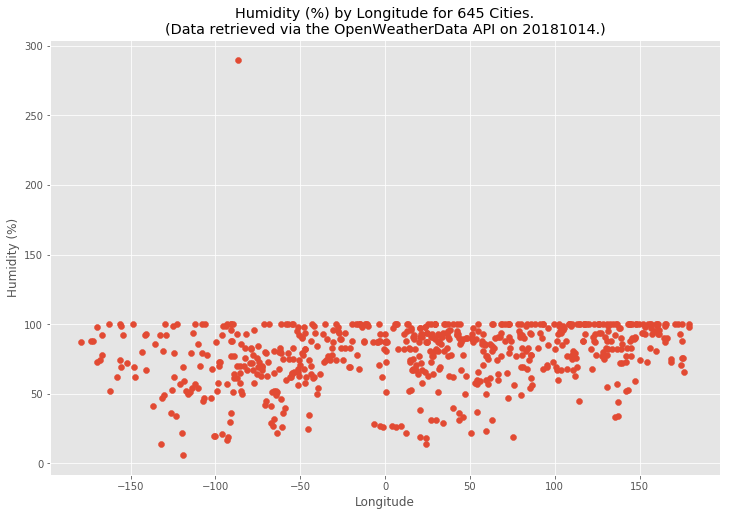

In [19]:
# Longitude vs Humidity
plt.scatter(city_df2["longitude"], city_df2["Humidity (%)"])
plt.xlabel("Longitude")
plt.ylabel("Humidity (%)")
plt.title(f"Humidity (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_hum_{}.png".format(today))
plt.show()

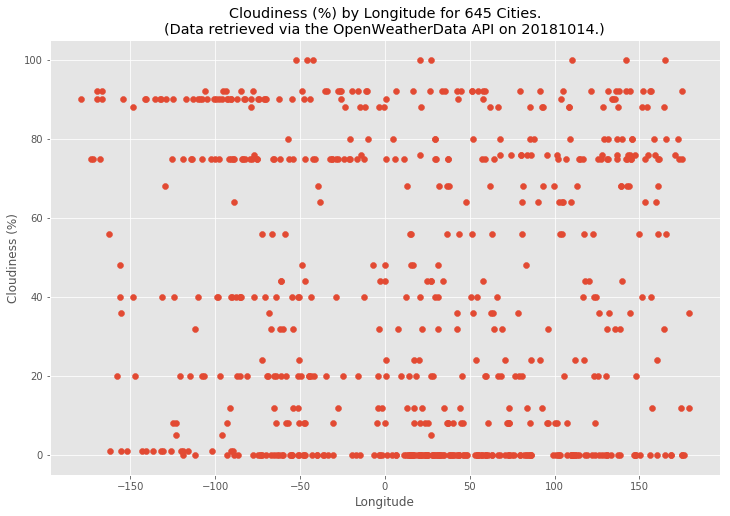

In [20]:
# Longitude vs Cloudiness
plt.scatter(city_df2["longitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Longitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_cloud_{}.png".format(today))
plt.show()

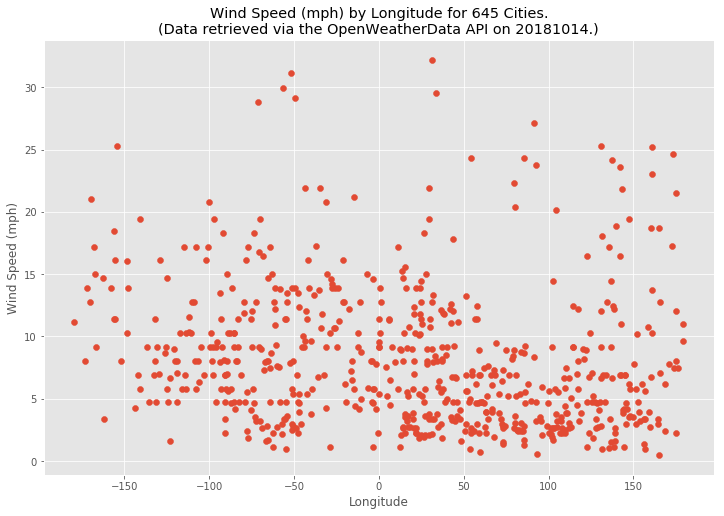

In [21]:
# Longitude vs Wind Speed
plt.scatter(city_df2["longitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Longitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_wind_{}.png".format(today))
plt.show()

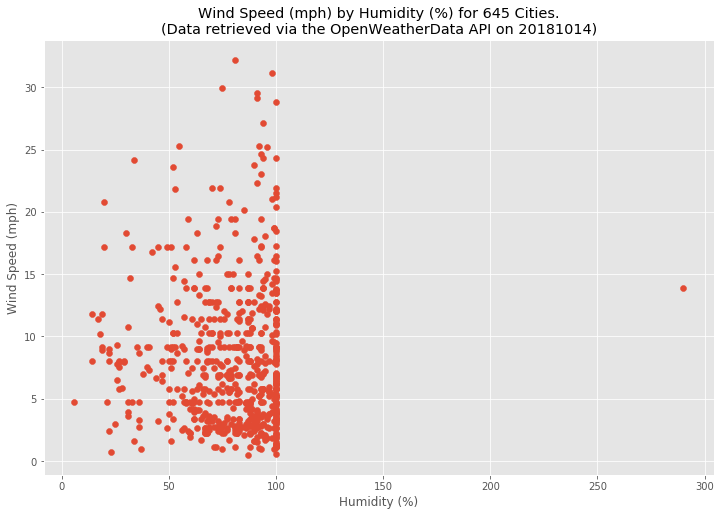

In [22]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Humidity (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today})")

# Save image
plt.savefig("Images/hum_wind_{}.png".format(today))
plt.show()

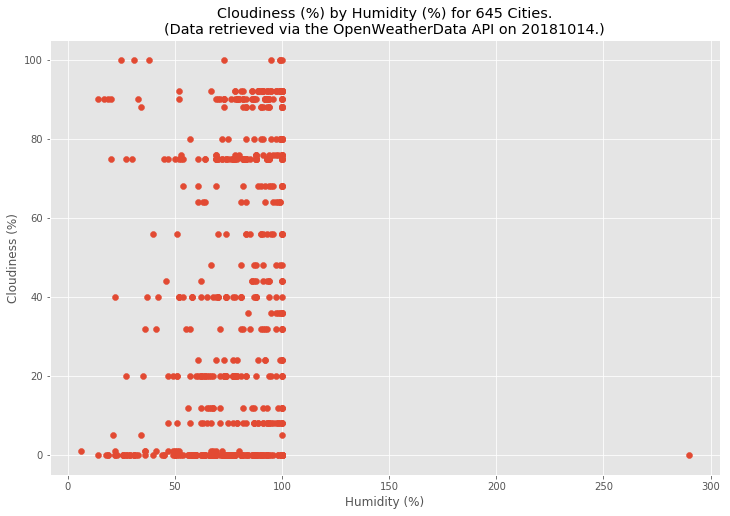

In [23]:
# Humidity vs Cloudiness
plt.scatter(city_df2["Humidity (%)"], city_df2["Cloudiness (%)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/hum_cloud_{}.png".format(today))
plt.show()

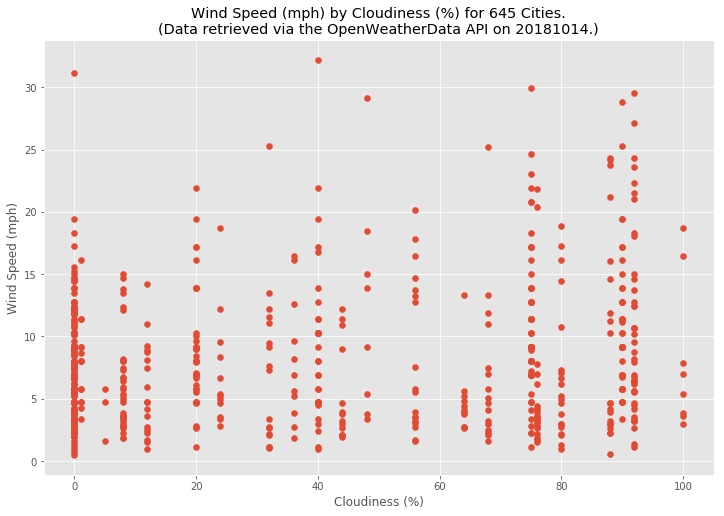

In [24]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Cloudiness (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Cloudiness (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Cloudiness (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/cloud_wind_{}.png".format(today))
plt.show()